## Optimizing NN architecture using Neuroevolution
Custom pipeline for model instantiation and neuroevolution procedure

### Must Remember points  
**__ getattribute __ can be used to convert string to a method or class call**  
**When using Crossentropy loss use logits as the network output**  
**Skorch neuralnetclassifier can be used to validate results and build custom pipeline**

### Step1 : Defining Neural Net and Validation Methods

In [55]:
from sklearn import datasets
import torch
from torch import nn
from sklearn import model_selection
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
import math
import skorch

In [102]:
# cv = model_selection.KFold(n_splits=3,shuffle=True,random_state=42)

# for train_index,test_index in cv.split(x):
    
#     x_train, y_train = x[train_index], y[train_index]
#     x_val, y_val = x[test_index], y[test_index]
    
#     x_tr_ten = torch.FloatTensor(x_train)
#     y_tr_ten = torch.LongTensor(y_train)

#     trainloader = TensorDataset(torch.FloatTensor(x_train),torch.LongTensor(y_train))

#     x_te_ten = torch.FloatTensor(x_val)
#     y_te_ten = torch.LongTensor(y_val)

#     testloader = TensorDataset(torch.FloatTensor(x_val),torch.LongTensor(y_val))

#     trainer = DataLoader(trainloader,batch_size=5)
#     tester = DataLoader(testloader,batch_size=5)

In [205]:
# from skorch import NeuralNetClassifier
# import numpy as np

# neural_net = NeuralNetClassifier(NN_Model(6,0,'relu','relu'),optimizer=torch.optim.Adam,lr=0.08)

# X,Y = x.astype(np.float32), y.astype(np.int64)

# neural_net.fit(X,Y)

# model_selection.cross_val_score(neural_net,X,Y)

In [103]:
data = datasets.load_iris()
x = data['data']
y = data['target']

In [270]:
individual_accuracy([6,0,0.5,1.7,0.03,1.6])

63.333333333333336

In [322]:
def individual_accuracy(params_list):
    
    accuracy_list = kfold_accuracy(params_list,x,y,3)
    #return sum(accuracy_list)/len(accuracy_list)
    return accuracy_list

In [261]:
def kfold_accuracy(params_list,x,y,splits=3):
    
    kfold_accuracy = []
    kfold = model_selection.KFold(n_splits=splits,shuffle=True,random_state=42)

    for train_index,test_index in kfold.split(x):
    
        x_train, y_train = x[train_index], y[train_index]
        x_val, y_val = x[test_index], y[test_index]
    
#         x_tr_ten = torch.FloatTensor(x_train)
#         y_tr_ten = torch.LongTensor(y_train)

        trainloader = TensorDataset(torch.FloatTensor(x_train),torch.LongTensor(y_train))

#         x_te_ten = torch.FloatTensor(x_val)
#         y_te_ten = torch.LongTensor(y_val)

        testloader = TensorDataset(torch.FloatTensor(x_val),torch.LongTensor(y_val))

        trainer = DataLoader(trainloader,batch_size=5)
        tester = DataLoader(testloader,batch_size=5)
        
        kfold_accuracy.append(get_accuracy(params_list))
        
    return kfold_accuracy

In [250]:
class NN_Model(nn.Module):
    
    def __init__(self,layer_1,layer_2,activation_1,activation_2):
        
        super().__init__()
        
        self.hidden1 = nn.Linear(4,layer_1)
        
        self.layer_2 = False
        
        if layer_2>3:
            
            self.layer_2 = True
 
            self.hidden2 = nn.Linear(layer_1,layer_2)
        
            self.output = nn.Linear(layer_2,3)
        
        else:
            self.output = nn.Linear(layer_1,3)
        
        self.activation1 = torch.__getattribute__(activation_1)
        
        self.activation2 = torch.__getattribute__(activation_2)
        
    def forward(self,x):
        
        x = x.view(-1,4)
        
        x = self.activation1(self.hidden1(x))
        
        if self.layer_2:
            
            x = self.activation2(self.hidden2(x))
        
        x = torch.log_softmax(self.output(x),dim=1)
        
        #TODO: When using Cross-Entropy loss as criterion
        #x = self.output(x)
        
        return x

In [289]:
def convert_params(input_list):
    
    activation_fn = ["sigmoid","relu","tanh"]
    optimizer_fn = ["Adam","SGD","Adagrad"]
    
    layer1 = round(input_list[0])
    
    layer2 = round(input_list[1])
    
    activation1 = activation_fn[math.floor(input_list[2])]
    
    activation2 = activation_fn[math.floor(input_list[3])]
    
    learning_rate = input_list[4]
    
    optimizer = optimizer_fn[math.floor(input_list[5])]
    
    return layer1, layer2, activation1, activation2, learning_rate, optimizer    

In [251]:
def get_accuracy(params_list):
    
    """The function takes the input of the floating number encoded chromosome and returns the accuracy as thr output"""
    
    layer1, layer2, activation1, activation2, learning_rate, optimizer = convert_params(params_list)
    
    classifier = NN_Model(layer1, layer2, activation1, activation2)
    
    if torch.cuda.is_available:
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")

    classifier.to(device)

    loss_function = nn.NLLLoss()
    
    opt = torch.optim.__getattribute__(optimizer)
    
    optimizer = opt(classifier.parameters(),lr=learning_rate)
    
    accuracy = train(classifier,optimizer,loss_function,trainer,tester,epochs=10)
    
    #return max(accuracy)
    return sum(accuracy)/len(accuracy)

In [257]:
get_accuracy([6,2,0.5,1.7,0.03,1.6])

61.66666666666667

In [383]:
def train(model,optimizer,loss_fun,trainloader,testloader,epochs=15,device="cuda"):
    
    tr_list = []
    val_list = []
    acc_list = []
    epoch_list = [i+1 for i in range(epochs)]
    
    for epoch in range(epochs):
        
        training_loss = 0
        validation_loss = 0
        model.train()                #--------------------->Allows for parameters to be updated by backpropagation
        
        for batch in trainloader:
            
            optimizer.zero_grad()
            inputs,labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = loss_fun(outputs,labels)
            loss.backward()
            optimizer.step()
            
            training_loss += loss.item()
        
        model.eval()              #------------------------>Freezes the parameters for model validation
        correct_pred = 0
        total_pred = 0
        
        for batch in testloader:
            
            inputs,labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = loss_fun(outputs,labels)
            
            validation_loss +=loss.item()
            
            ps = torch.exp(outputs)         #-------------->The final activation function is Log_Softmax that's why we take exp
            
            correct = torch.eq(torch.max(ps,dim=1)[1],labels).view(-1)
            
            correct_pred += torch.sum(correct).item()
            total_pred += correct.shape[0]       #--------->Alternatively can also write batch.shape[0]
            
        training_loss = training_loss/len(trainloader)
        validation_loss = validation_loss/len(testloader)
        
        tr_list.append(training_loss)
        val_list.append(validation_loss)
        acc_list.append((correct_pred*100.0/total_pred))
    
    print("Mean Accuracy: {}".format(sum(acc_list)/len(acc_list)))
    print("Max Accuracy: {} at Epoch: {}".format(max(acc_list),acc_list.index(max(acc_list))))
            
    print("Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}"
              .format(epoch+1, training_loss,validation_loss, correct_pred * 100.0 / total_pred))
    
    fig = plt.figure(figsize=(20,6))
        
    plt.subplot(1,3,1)
    plt.plot(epoch_list,tr_list)
    plt.title("Training Loss")
    
    plt.subplot(1,3,2)
    plt.plot(epoch_list,val_list)
    plt.title("Validation Loss")
    
    plt.subplot(1,3,3)
    plt.plot(epoch_list,acc_list)
    plt.title("Accuracy")
    
    plt.savefig('Opti_graph2.png')
    plt.show()
   
    
    return acc_list

### Step 2: Evolving Solution using Genetic Algorithm

In [329]:
from deap import tools
from deap import base
from deap import creator
import random
import elitism
import numpy as np
import seaborn as sns

In [273]:
BOUNDS_LOW =  [5 , -5 , 0     , 0     , 0.001 , 0    ]
BOUNDS_HIGH = [15, 10 , 2.999 , 2.999 , 1.0   , 2.999]

In [336]:
POPULATION_SIZE = 20
P_CROSSOVER = 0.9
P_MUTATION = 0.2
MAX_GENERATIONS = 8
HALL_OF_FAME_SIZE = 3
CROWDING_FACTOR = 10.0
NUM_OF_PARAMS = len(BOUNDS_HIGH)

In [275]:
creator.create("FitnessMax",base.Fitness,weights=(1.0,))
creator.create("Individual",list,fitness=creator.FitnessMax)

In [278]:
toolbox = base.Toolbox()
for i in range(NUM_OF_PARAMS):
    toolbox.register("attribute_"+str(i),random.uniform,BOUNDS_LOW[i],BOUNDS_HIGH[i])

In [304]:
attributes = ()
for i in range(NUM_OF_PARAMS):
    attributes += (toolbox.__getattribute__("attribute_"+str(i)),)

In [305]:
toolbox.register("individualCreator",tools.initCycle,creator.Individual,attributes,n=1)
toolbox.register("populationCreator",tools.initRepeat,list,toolbox.individualCreator)

In [323]:
def classification_accuracy(individual):
    accuracy = individual_accuracy(individual)
    return sum(accuracy)/len(accuracy),
    
toolbox.register("evaluate",classification_accuracy)

In [319]:
toolbox.register("select",tools.selTournament,tournsize=2)
toolbox.register("mate",tools.cxSimulatedBinaryBounded,low=BOUNDS_LOW,up=BOUNDS_HIGH,eta=CROWDING_FACTOR)
toolbox.register("mutate",tools.mutPolynomialBounded,low=BOUNDS_LOW,up=BOUNDS_HIGH,eta=CROWDING_FACTOR,indpb=1.0/NUM_OF_PARAMS)

In [339]:
def main():
    
    
    population = toolbox.populationCreator(n=POPULATION_SIZE)

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("max", np.max)
    stats.register("avg", np.mean)


    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

    population, logbook = elitism.eaSimpleWithElitism(population,toolbox,cxpb=P_CROSSOVER,mutpb=P_MUTATION,ngen=MAX_GENERATIONS,
                                                      stats=stats,halloffame=hof,verbose=True)



    # print best solution found:

    print("- Best solutions are:")
    for i in range(HALL_OF_FAME_SIZE):
        print(i, ": ", hof.items[i].fitness.values[0], " -> ", convert_params(hof.items[i]))



    # plot statistics:

    maxFitnessValues, meanFitnessValues = logbook.select("max", "avg")
    plt.figure(1)
    sns.set_style("whitegrid")
    plt.plot(maxFitnessValues, color='red')
    plt.plot(meanFitnessValues, color='green')
    plt.xlabel('Generation')
    plt.ylabel('Max / Average Fitness')
    plt.title('Max and Average fitness over Generations')
    plt.savefig('Graph.png')
    
    #print("- Best solution is: \n",(convert_params(hof.items[0])),"\n => accuracy = ",hof.items[0].fitness.values[0])

gen	nevals	max    	avg    
0  	20    	78.6667	54.9222
1  	14    	88.8889	66.9111
2  	16    	92.1111	79.1167
3  	12    	92.1111	73.9222
4  	16    	92.1111	81.8611
5  	15    	92.4444	86.1333
6  	11    	92.4444	87.6444
7  	14    	92.4444	86.6056
8  	14    	93     	87.0111
- Best solutions are:
0 :  93.0  ->  (7, 1, 'relu', 'tanh', 0.15929789673111547, 'Adagrad')
1 :  92.8888888888889  ->  (7, 1, 'relu', 'tanh', 0.1593428012440026, 'Adagrad')
2 :  92.44444444444446  ->  (7, 1, 'relu', 'tanh', 0.1586752701884665, 'Adagrad')


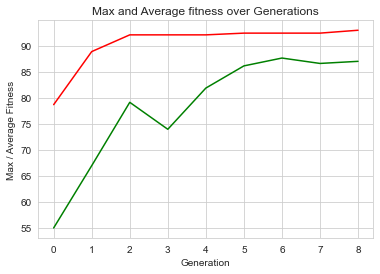

In [340]:
main()

In [321]:
main()

gen	nevals	max    	avg    
0  	20    	92.1111	49.7556
1  	16    	92.5556	70.8444
2  	14    	92.5556	84.1833
3  	14    	94.5556	87.8722
4  	16    	97.1111	87.6111
5  	13    	97.1111	88.2   
- Best solution is: 
 (10, 7, 'relu', 'tanh', 0.02755842875464165, 'Adagrad') 
 => accuracy =  94.99999999999999


In [344]:
individual_accuracy([7,1,1.5,2.4,0.15929,2.5])

[91.00000000000001, 88.66666666666669, 95.99999999999999]

In [343]:
individual_accuracy([10,7,1.5,2.4,0.02755,2.5])

[90.33333333333333, 93.66666666666669, 92.66666666666667]

Mean Accuracy: 91.66666666666664
Max Accuracy: 96.66666666666667 at Epoch: 5
Epoch: 10, Training Loss: 0.31, Validation Loss: 0.27, accuracy = 96.67


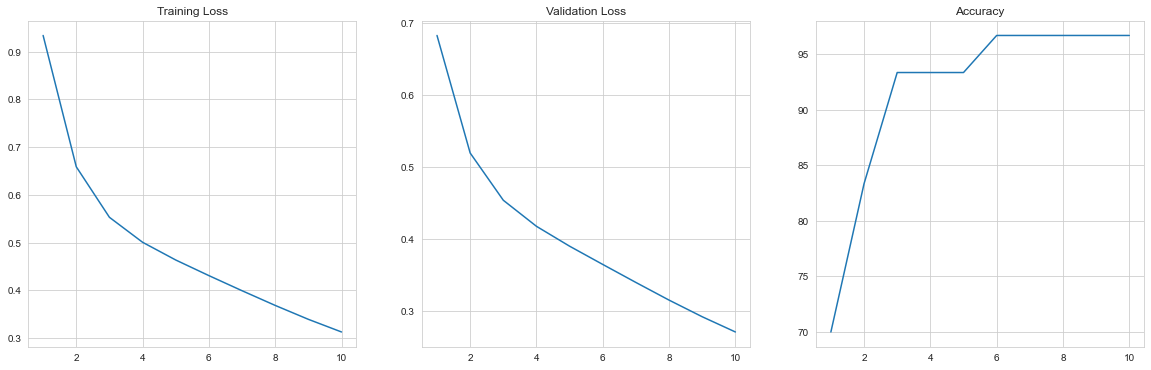

91.66666666666664

In [382]:
#Opti_graph1
get_accuracy([10,7,1.5,2.4,0.02755,2.5])

Mean Accuracy: 90.0
Max Accuracy: 96.66666666666667 at Epoch: 7
Epoch: 10, Training Loss: 0.18, Validation Loss: 0.17, accuracy = 96.67


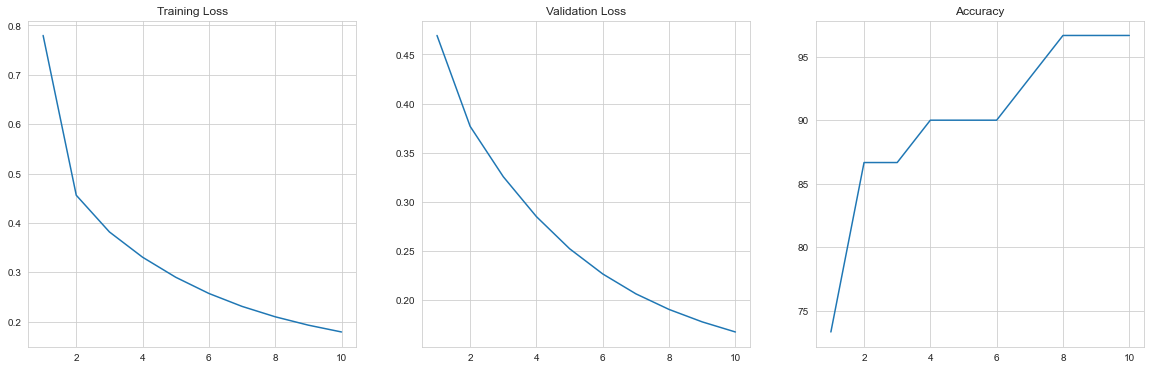

90.0

In [385]:
#Opti_graph2
get_accuracy([7,1,1.5,2.4,0.15929,2.5])